# **0. Libraries**

In [1]:
!pip install pandas-profiling==2.7.1

In [23]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

#Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# **1. Dataset**

In [3]:
df = pd.read_csv(r'C:\Users\g_fma\OneDrive\Área de Trabalho\DOCS\data_projects\projects_git\kaggle_heart_disease\data\.csv\heart.csv')

In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 1.1 Variable Dictionary

01. age - idade em anos
02. sex - M = 1 e F = 0
03. chest pain type (4 values)
04. resting blood pressure
05. serum cholestoral in mg/dl  
06. fasting blood sugar > 120 mg/dl - Teste diabetico
07. resting electrocardiographic results (values 0,1,2)
08. maximum heart rate achieved
09. exercise induced angina - SIM = 1 e NAO = 0
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

# **2. Exploratory Analysis**

In [5]:
df.shape

(303, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
profile = ProfileReport(df, minimal=True)
profile

Summarize dataset: 23it [00:00, 153.77it/s, Completed]
Render HTML: 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


<AxesSubplot:>

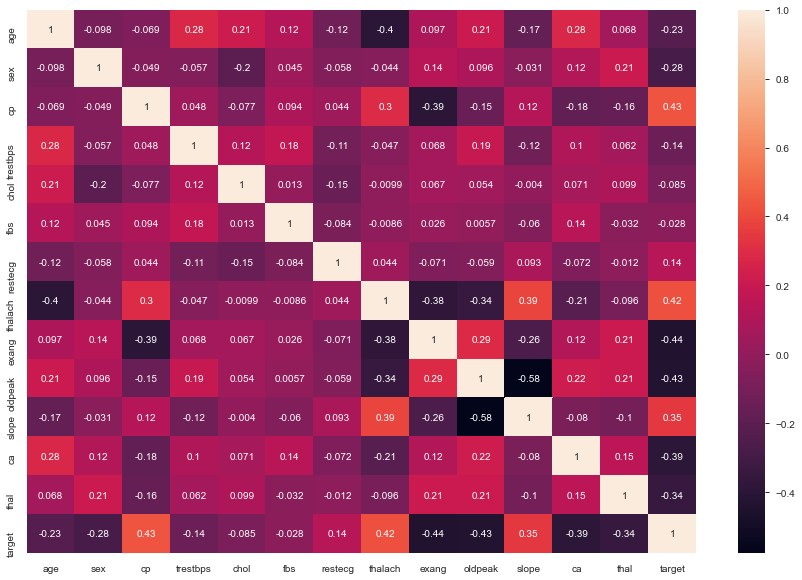

In [8]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True)

In [9]:
df.corr()['target'].sort_values(ascending=False)

target      1.000000
cp          0.433798
thalach     0.421741
slope       0.345877
restecg     0.137230
fbs        -0.028046
chol       -0.085239
trestbps   -0.144931
age        -0.225439
sex        -0.280937
thal       -0.344029
ca         -0.391724
oldpeak    -0.430696
exang      -0.436757
Name: target, dtype: float64

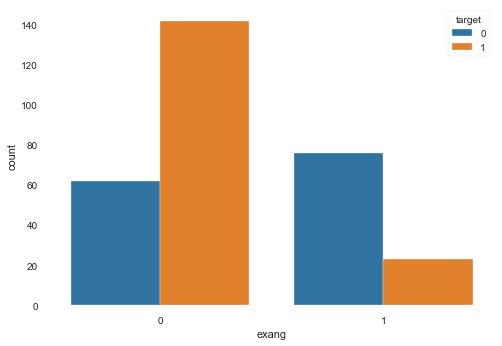

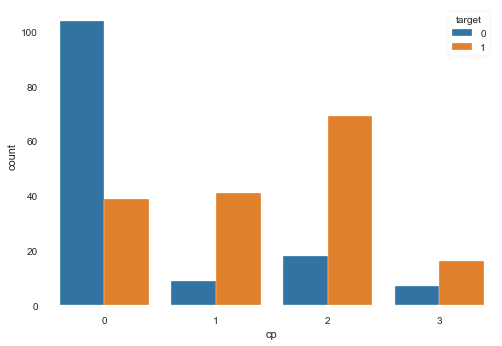

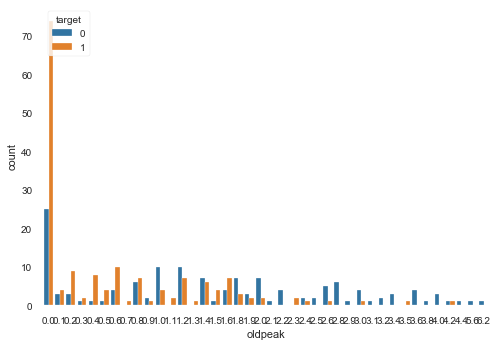

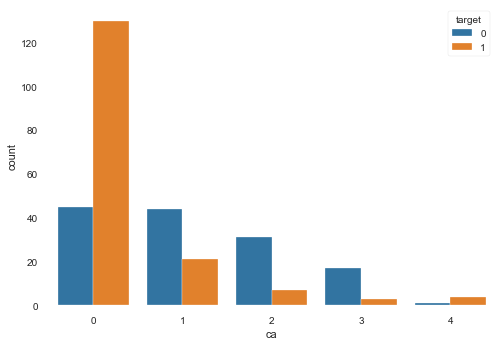

In [10]:
strong_corr = ['exang','cp','oldpeak','ca']
for i in strong_corr:
    sns.countplot(data=df,x=i,hue='target')
    plt.show()

## 2.1 Main Analysis

* **Correlações Fortes (~0,40)**:
    * "exang" com o **TARGET** = Quanto **<span style="color:red">menos</span>** exercicios fisicos que geraram Angina **<span style="color:green">mais</span>** doenças coronárias.
    * "cp" com o **TARGET** = Quanto **<span style="color:green">maior</span>** o nível de dor **<span style="color:green">mais</span>** doenças coronárias.
    * "oldpeak" com o **TARGET** = Quanto **<span style="color:red">menos</span>** depressão de ST induzida por exercício **<span style="color:green">mais</span>** doenças coronárias.
    * "ca" com o **TARGET** = Quanto **<span style="color:red">menos</span>** número de vasos sanguínios ressaltados **<span style="color:green">mais</span>** doenças coronárias.
    * "oldpeak com "slope" = Quanto **<span style="color:red">menos</span>** depressão de ST induzida por exercício **<span style="color:green">maior</span>** o tipo de inclinação do segmento ST de pico do exercício

* **Correlações Fracas**:
    * "fbs" com o **TARGET** = Teste diabético parece não influenciar tanto em casos de doenças coronárias.
    * "chol" com o **TARGET** = Nível de colesterol parece não influenciar tanto em casos de doenças coronárias.
    
---
* **Data Cleaning**
    * Possíveis outliers na variável "chol"
    * Presença de uma linha duplicada
---
* **Feature Selection**
    * "fbs" é uma variável que deve ser avaliada quanto a sua permanência no modelo. Além de possuir baixa correlação com as outras variáveis e com o TARGET, ainda apresenta significativo desbalanceamento.

## 2.2 Data Cleaning

### 2.2.1 Outliers

In [11]:
z=np.abs(stats.zscore(df['chol']))
z[z>=3].shape[0]

4

In [12]:
#Por se tratar de somente 4 valores, eles serão removidos
df = df[z<3]
df.shape

(299, 14)

### 2.2.2 Duplicates

In [13]:
df.drop_duplicates(inplace=True)
df.shape

<ipython-input-13-abad02d476d4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


(298, 14)

# **3. Feature Engineering**

## 3.1 New Features

# **4. Modeling**

## 4.1 Select Technique

**Problema de Classificação - Modelo Supervisionado**

*Métricas de Avaliação*

* F1
* Recall
* Precisão

*Modelos Avaliados*

* Logistic Regression - Sklearn
* KNN - Sklearn
* Naive Bayes - Sklearn
* Rede Neural - Sklearn
* Random Forest - Sklearn
* Support Vector Classification - Sklearn
* XGBoost - XGB

Os treinamentos serão feitos considerando os hiperparâmetros dados por default, com uma massa de teste aleatória de **20%**

Os dados serão normalizados utilizando o método de StandardScaler 

O modelo com maior **F1** será segregado para etapa de tunning de seus hiperparâmetros

In [14]:
X = df.drop(columns=['target'])
y = df['target']

In [15]:
#Separação das amostras de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=7)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(238, 13)
(60, 13)
(238,)
(60,)


In [17]:
#Normalização dos dados
scaler = StandardScaler().fit(X_train)

X_trainS = scaler.transform(X_train)
X_testS = scaler.transform(X_test)

X_train = pd.DataFrame(X_trainS,columns = X_train.columns)
X_test = pd.DataFrame(X_testS,columns = X_test.columns)

In [18]:
#Linha de base referente à decisão aleatória
base_line = df['target'].value_counts()[0]/df['target'].value_counts().sum()
print(f'BaseLine = {round(base_line,2)}%')

BaseLine = 0.46%


In [19]:
#Definindo os Classificadores
lg = LogisticRegression()
knn = KNeighborsClassifier()
nb_gaussian = GaussianNB()
mlp = MLPClassifier()
rf = RandomForestClassifier()
svc = SVC()
xgb = xgb.XGBClassifier()

In [20]:
#Formula para aplicação dos modelos
def apply_model(clf):
    model = clf.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    f1 = round(f1_score(y_test,y_pred),2)*100
    precision = round(precision_score(y_test,y_pred),2)*100
    recall = round(recall_score(y_test,y_pred),2)*100
    return f1, precision, recall

In [21]:
#Aplicação do modelo
models = [lg,knn,nb_gaussian,mlp,rf,svc,xgb]
f1 = []
precision = []
recall = []

for i in models:
    f1_value, precision_value, recall_value = apply_model(i)
    f1.append(f1_value)
    precision.append(precision_value)
    recall.append(recall_value)

C:\Users\g_fma\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\g_fma\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:04:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [22]:
#Ranking de modelos
models_name = ['Logistic Regression','KNN','Gaussian Naive Bayes','MLP','Random Forest','SVC','XGBoost']
result = dict(zip(models_name,zip(f1,precision,recall)))
df_results = pd.DataFrame(result).T.rename(columns={0:'F1',1:'Precsion',2:'Recall'}).sort_values(by='F1', ascending=False)
df_results

,F1,Precsion,Recall
SVC,81.0,78.0,83.0
Logistic Regression,80.0,74.0,87.0
KNN,77.0,71.0,83.0
MLP,77.0,75.0,80.0
Random Forest,76.0,73.0,80.0
XGBoost,76.0,73.0,80.0
Gaussian Naive Bayes,72.0,71.0,73.0


## **4.2 Tunning**

*Parâmetros SVC:*
* C: float, default=1.0
* kernel: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’
* degree: int, default=3
* gamma: {‘scale’, ‘auto’} or float, default=’scale’
* coef0: float, default=0.0
* shrinking: bool, default=True
* probability: bool, default=False
* tol: float, default=1e-3
* cache_size: float, default=200
* class_weight: dict or ‘balanced’, default=None
* verbose: bool, default=False
* max_iter: int, default=-1
* decision_function_shape: {‘ovo’, ‘ovr’}, default=’ovr’
* break_ties: bool, default=False
* random_state: int, RandomState instance or None, default=None

In [37]:
paramters_rgrid = {
    'C':range(1,11),
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':range(1,11),
    'gamma':['scale', 'auto'],
    'coef0':[0,1,2],
    'shrinking':[True,False],
    'probability':[True,False],
    'class_weight':['balanced',None],
    'decision_function_shape':['ovo','ovr']
}

In [50]:
#Procurando parâmetros aleatórios para 
rgrid_svc = RandomizedSearchCV(estimator=svc,param_distributions=paramters_rgrid,scoring='f1',n_jobs=-1,cv=5,verbose=True,random_state=7)

rgrid_svc.fit(X_train,y_train)
rgrid_svc_best = rgrid_svc.best_estimator_
y_rgrid_svc = rgrid_svc_best.predict(X_test)

print('F1: {:.2f}%'.format(f1_score(y_test,y_rgrid_svc)*100))
print('Precision: {:.2f}%'.format(precision_score(y_test,y_rgrid_svc)*100))
print('Recall: {:.2f}%'.format(recall_score(y_test,y_rgrid_svc)*100))
print(rgrid_svc.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
F1: 82.35%
Precision: 73.68%
Recall: 93.33%
{'shrinking': False, 'probability': False, 'kernel': 'poly', 'gamma': 'auto', 'degree': 1, 'decision_function_shape': 'ovo', 'coef0': 1, 'class_weight': None, 'C': 1}


In [47]:
paramters_grid = {
    'C':[1,2,3],
    'kernel':['poly', 'rbf', 'sigmoid'],
    'degree':[1,2,3],
    'gamma':['auto'],
    'coef0':[1,2],
    'shrinking':[True,False],
    'probability':[False],
    'class_weight':['balanced',None],
    'decision_function_shape':['ovo','ovr']
}

In [49]:
#Aplicando 
grid_svc = GridSearchCV(estimator=svc,param_grid=paramters_grid,scoring='f1',n_jobs=-1,cv=5,verbose=True)

grid_svc.fit(X_train,y_train)
grid_svc_best = grid_svc.best_estimator_
y_grid_svc = grid_svc_best.predict(X_test)

print('F1: {:.2f}%'.format(f1_score(y_test,y_grid_svc)*100))
print('Precision: {:.2f}%'.format(precision_score(y_test,y_grid_svc)*100))
print('Recall: {:.2f}%'.format(recall_score(y_test,y_grid_svc)*100))
print(grid_svc.best_params_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
F1: 81.82%
Precision: 75.00%
Recall: 90.00%
{'C': 1, 'class_weight': 'balanced', 'coef0': 2, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': False, 'shrinking': True}


# **5. Results**

*Análises*


*Modelo*
* Foi definido o modelo **Support Vector Classification (SVC)** do Sklearn por apresentar melhor resultado de F1 = **82,35%**